In [1]:
import wandb
wandb.login()  # Opens a browser once to authenticate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import resnet50
from itertools import product
import numpy as np
import random
import copy
import os, ssl, zipfile, urllib
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from sklearn.metrics import confusion_matrix
import seaborn as sns



wandb: Currently logged in as: analiju (analiju-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Number of visible GPUs: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}") # Will show the name of the *visible* GPU 0

CUDA available: True
Number of visible GPUs: 3
Current device: 0
Device name: Quadro RTX 5000


In [3]:

TARGET_GPU_INDEX = 2

if torch.cuda.is_available():
    if TARGET_GPU_INDEX < torch.cuda.device_count():
        DEVICE = torch.device(f"cuda:{TARGET_GPU_INDEX}")
        print(f"Successfully set to use GPU: {TARGET_GPU_INDEX} ({torch.cuda.get_device_name(TARGET_GPU_INDEX)})")
    else:
        print(f"Error: Physical GPU {TARGET_GPU_INDEX} is not available. There are only {torch.cuda.device_count()} GPUs (0 to {torch.cuda.device_count() - 1}).")
        print("Falling back to CPU.")
        DEVICE = torch.device("CPU")
else:
    print("CUDA is not available. Falling back to CPU.")
    DEVICE = torch.device("CPU")

print(f"Final DEVICE variable is set to: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"Current PyTorch default device: {torch.cuda.current_device()}")
    torch.cuda.set_device(TARGET_GPU_INDEX)
    print(f"Current PyTorch default device (after set_device): {torch.cuda.current_device()}")


dummy_tensor = torch.randn(2, 2)
dummy_tensor_on_gpu = dummy_tensor.to(DEVICE)
print(f"Dummy tensor is on device: {dummy_tensor_on_gpu.device}")

Successfully set to use GPU: 2 (Quadro RTX 5000)
Final DEVICE variable is set to: cuda:2
Current PyTorch default device: 0
Current PyTorch default device (after set_device): 2
Dummy tensor is on device: cuda:2


In [4]:
DEVICE

device(type='cuda', index=2)

In [5]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Number of visible GPUs: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}") # Will show the name of the *visible* GPU 0

CUDA available: True
Number of visible GPUs: 3
Current device: 2
Device name: Quadro RTX 5000


In [ ]:

LOCAL_OR_COLAB = "LOCAL"
SEED           = 42
NUM_EPOCHS     = 34

TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1

# hyperparameter grid
BATCH_SIZES = [128]  
LRS = [1e-4, 3e-4]

GRID        = [
    (3.75e-4, 0.5  ),
]

BETAS=(0.9,0.98)
EPS = 1e-8

if LOCAL_OR_COLAB == "LOCAL":
    DATA_DIR = "/share/DEEPLEARNING/carvalhj/EuroSAT_RGB/"
else:
    data_root = "/content/EuroSAT_RGB"
    zip_path  = "/content/EuroSAT.zip"
    if not os.path.exists(data_root):
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip", zip_path
        )
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall("/content")
        os.rename("/content/2750", data_root)
    DATA_DIR = data_root

NUM_WORKERS = 4 

In [7]:

def compute_mean_std(dataset, batch_size):
    loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=NUM_WORKERS)
    mean = 0.0
    std = 0.0
    n_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean.tolist(), std.tolist()

def get_split_indexes(labels, total_count):
    indices = np.arange(total_count)
    np.random.seed(SEED) # for reproducibility
    np.random.shuffle(indices)

    train_split = int(0.8 * total_count)
    val_split = int(0.9 * total_count)

    train_idx = indices[:train_split]
    val_idx = indices[train_split:val_split]
    test_idx = indices[val_split:]
    return train_idx, val_idx, test_idx

def get_data_loaders(data_dir, batch_size):

    base_tf = transforms.ToTensor()
    ds_all = datasets.ImageFolder(root=data_dir, transform=base_tf)
    labels = np.array(ds_all.targets)
    num_classes = len(ds_all.classes)
    total_count = len(ds_all)
    print(f"Total samples in folder: {total_count}, classes: {ds_all.classes}")

    train_idx, val_idx, test_idx = get_split_indexes(labels, total_count)

    train_subset_for_stats = Subset(ds_all, train_idx)
    mean, std = compute_mean_std(train_subset_for_stats, batch_size)
    print(f"Computed mean: {mean}")
    print(f"Computed std:  {std}")


    train_transform_augmented = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomApply([transforms.RandomRotation(angle) for angle in [0, 90, 180, 270]], p=1.0), # Apply one of 0, 90, 180, 270 rotations
        transforms.RandomHorizontalFlip(p=0.5), # Randomly apply horizontal flip (50% chance)
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


    # Transformations for EVALUATION (validation and test): resize, central crop, ToTensor, Normalize
    eval_transform = transforms.Compose([
        transforms.Resize(256), # Resize to 256x256
        transforms.CenterCrop(224), # Perform a central crop of 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Create datasets with the respective transformations
    train_ds = datasets.ImageFolder(root=data_dir, transform=train_transform_augmented)
    val_ds = datasets.ImageFolder(root=data_dir, transform=eval_transform)
    test_ds = datasets.ImageFolder(root=data_dir, transform=eval_transform)

    # Apply subsets to the transformed datasets
    train_ds_subset = Subset(train_ds, train_idx)
    val_ds_subset = Subset(val_ds, val_idx)
    test_ds_subset = Subset(test_ds, test_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_ds_subset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    val_loader   = DataLoader(val_ds_subset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    test_loader  = DataLoader(test_ds_subset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))

    print(f"Train/Val/Test splits: {len(train_ds_subset)}/{len(val_ds_subset)}/{len(test_ds_subset)}")

    return train_loader, val_loader, test_loader, num_classes

In [8]:

def get_proportion(num_classes, dataset):
    return np.bincount(np.array(dataset.dataset.targets)[dataset.indices], minlength=num_classes) / len(dataset)

def get_split_indexes(labels, total_count):
    n_train = int(np.floor(TRAIN_FRAC * total_count))
    n_temp = total_count - n_train   # this is val + test

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_train,
        test_size=n_temp,
        random_state=SEED
    )
    # Train and temp(val+test) indices
    train_idx, temp_idx = next(sss1.split(np.zeros(total_count), labels))

    n_val = int(np.floor(VAL_FRAC * total_count))
    n_test = total_count - n_train - n_val
    assert n_temp == n_val + n_test, "Fractions must sum to 1."

    labels_temp = labels[temp_idx]

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_val,
        test_size=n_test,
        random_state=SEED
    )
    val_idx_in_temp, test_idx_in_temp = next(sss2.split(np.zeros(len(temp_idx)), labels_temp))

    val_idx = temp_idx[val_idx_in_temp]
    test_idx = temp_idx[test_idx_in_temp]

    assert len(train_idx) == n_train
    assert len(val_idx) == n_val
    assert len(test_idx) == n_test

    print(f"Stratified split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")
    return train_idx,val_idx,test_idx



In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def build_model(n_cls, pretrained=False):
    m = resnet50(weights=None if not pretrained else "DEFAULT")
    m.fc = nn.Linear(m.fc.in_features, n_cls)
    return m.to(DEVICE)

def train_one_epoch(model, loader, opt, crit, sched=None):
    model.train()
    tot_loss, corr, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        logits = model(xb)

        loss   = crit(logits, yb)
        loss.backward()
        opt.step()
        if sched: sched.step()
        tot_loss += loss.item()
        preds    = logits.argmax(dim=1)
        corr    += (preds==yb).sum().item()
        tot     += yb.size(0)
        avg_loss = tot_loss / len(loader)

    avg_loss = tot_loss / len(loader)
    acc = 100.0 * corr / tot
    return avg_loss, acc

def evaluate(model, loader, num_classes):
    model.eval()

    total_correct = 0
    total_samples = 0

    correct_per_class = torch.zeros(num_classes, dtype=torch.int64)
    total_per_class   = torch.zeros(num_classes, dtype=torch.int64)

    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds  = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

            for c in range(num_classes):
                class_mask = (yb == c)
                if class_mask.sum().item() == 0:
                    continue

                total_per_class[c] += class_mask.sum().item()

                correct_per_class[c] += ((preds == yb) & class_mask).sum().item()

    overall_acc = 100.0 * total_correct / total_samples

    acc_per_class = {}
    for c in range(num_classes):
        if total_per_class[c].item() > 0:
            acc = 100.0 * correct_per_class[c].item() / total_per_class[c].item()
        else:
            acc = 0.0
        acc_per_class[c] = acc

    return overall_acc, acc_per_class, all_labels, all_preds

def plot_confusion_matrix_from_preds(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90)
    plt.yticks(ticks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # threshold for text color
    thresh = cm.max() / 2.0
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            pct = cm_norm[i, j] * 100
            plt.text(
                j, i,
                f"{cm[i, j]}\n{pct:.1f}%",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )
    
    plt.tight_layout()
    plt.show()

def plot_class_acc_prop(te_dl, acc_vals, class_proportions_test):
    classes = te_dl.dataset.dataset.classes
    x = np.arange(len(classes))

    acc   = acc_vals
    prop  = class_proportions_test * 100

    fig, ax1 = plt.subplots(figsize=(12,6))
    bars = ax1.bar(x, acc, color='C0', alpha=0.7)
    ax1.set_ylabel('Accuracy (%)', color='C0')
    ax1.set_ylim(0, 100)
    ax1.tick_params(axis='y', labelcolor='C0')

    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}%', ha='center', va='bottom', color='C0')

    ax2 = ax1.twinx()
    line = ax2.plot(x, prop, color='C1', marker='o', linewidth=2)
    ax2.set_ylabel('Test Proportion (%)', color='C1')
    ax2.set_ylim(0, max(prop)*1.2)
    ax2.tick_params(axis='y', labelcolor='C1')

    for xi, yi in zip(x, prop):
        ax2.text(xi, yi + max(prop)*0.02, f'{yi:.1f}%', ha='center', va='bottom', color='C1')

    ax1.set_xticks(x)
    ax1.set_xticklabels(classes, rotation=45, ha='right')
    plt.title('Per-class Accuracy vs. Test Proportion')
    plt.tight_layout()
    plt.show()


def hyperparam_search(pretrained=True):
    print(f"\n>>> Starting hyperparameter search with pretrained={pretrained}...")
    best_val = -1.0
    best_cfg = None
    best_model = None

    for bs, (lr, wd) in product(BATCH_SIZES, GRID):

        print(f"\n>>> Testing BS={bs}, LR={lr:.1e}")
        
        tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)
        model = build_model(n_cls, pretrained=pretrained)
        
        total_steps  = NUM_EPOCHS * len(tr_dl)
        warmup_steps = len(tr_dl)
        opt = optim.AdamW(model.parameters(), lr=lr, betas=BETAS, eps=float(EPS), weight_decay=wd)
        sched = SequentialLR(
            opt,
            schedulers=[
                LinearLR(opt,  start_factor=1e-6, end_factor=1.0, total_iters=warmup_steps),
                CosineAnnealingLR(opt, T_max=total_steps-warmup_steps)
            ],
            milestones=[warmup_steps]
        )
        crit  = nn.CrossEntropyLoss()

        # Start a W&B run
        wandb_run = wandb.init(
            project="eurosat-supervised-scratch-grid-search-augmented-largerbs",
            name=f"BS{bs}_LR{lr:.0e}_TR{TRAIN_FRAC}",
            config={
                "batch_size": bs,
                "learning_rate": lr,
                "epochs": NUM_EPOCHS,
                "pretrained": pretrained,
            }
        )

        for ep in range(NUM_EPOCHS):
            tr_loss, tr_acc = train_one_epoch(model, tr_dl, opt, crit, sched)
            # Compute validation loss & accuracy in one pass
            model.eval()
            val_loss, corr, tot = 0.0, 0, 0
            with torch.no_grad():
                for xb, yb in val_dl:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    logits = model(xb)
                    loss = crit(logits, yb)
                    val_loss += loss.item()
                    preds = logits.argmax(dim=1)
                    corr += (preds == yb).sum().item()
                    tot  += yb.size(0)
            val_loss /= len(val_dl)
            val_acc = 100.0 * corr / tot
        

            print(f"  Ep{ep+1}/{NUM_EPOCHS}: train_acc={tr_acc:.1f}%  train_loss={tr_loss:.4f}, "
                  f"val_acc={val_acc:.1f}%, val_loss={val_loss:.4f}")

            wandb.log({
                "epoch":       ep + 1,
                "train_loss":  tr_loss,
                "train_acc":   tr_acc,
                "val_loss":    val_loss,
                "val_acc":     val_acc
            })

        wandb_run.finish()

        if val_acc > best_val:
            best_val   = val_acc
            best_cfg   = (bs, lr, wd)
            best_model = copy.deepcopy(model)

    print(f"\n>>> Best config: BS={best_cfg[0]}, LR={best_cfg[1]:.1e}, val_acc={best_val:.1f}%")
    
    return best_cfg, best_model




# Perform Hyperparameter Search, Retrain on Train + Validation Set, Evaluate on Test Set

In [10]:
def make_optimizer_scheduler(params, lr, wd, steps_per_epoch, epochs):
    total_steps  = epochs * steps_per_epoch
    warmup_steps = steps_per_epoch
    opt = optim.AdamW(params, lr=lr, betas=(0.9,0.98), eps=1e-8, weight_decay=wd)
    sched = SequentialLR(
        opt,
        schedulers=[
            LinearLR(opt,  start_factor=1e-6, end_factor=1.0, total_iters=warmup_steps),
            CosineAnnealingLR(opt, T_max=total_steps - warmup_steps)
        ],
        milestones=[warmup_steps]
    )
    return opt, sched

def retrain_final_model(tr_dl, val_dl, n_cls, bs, lr, wd, num_epochs):

    combined_ds = ConcatDataset([tr_dl.dataset, val_dl.dataset])
    combined_dl = DataLoader(combined_ds, batch_size=bs, shuffle=True, num_workers=4)

    model = build_model(n_cls, pretrained=False)
    optimizer, scheduler = make_optimizer_scheduler(
        model.parameters(), lr, wd, len(combined_dl), num_epochs
    )
    criterion = nn.CrossEntropyLoss()

    for ep in range(num_epochs):
        loss, acc = train_one_epoch(model, combined_dl, optimizer, criterion, sched=scheduler)
        print(f"  Ep {ep+1}/{num_epochs}: train_acc={acc:.1f}%")
    return model, combined_ds

#  Evaluate & log to wandb
def evaluate_and_log(final_model, te_dl, combined_ds, n_cls, bs, lr):
    """
    Evaluate on test set, print per-class stats, log to wandb, and plot.
    """
    final_test_acc, acc_per_class, y_true, y_pred = evaluate(final_model, te_dl, n_cls)
    plot_confusion_matrix_from_preds(y_true, y_pred, te_dl.dataset.dataset.classes)

    test_targs = np.array(te_dl.dataset.dataset.targets)[te_dl.dataset.indices]
    prop_test = np.bincount(test_targs, minlength=n_cls) / len(test_targs)

    combined_targs = np.concatenate([
        np.array(ds.dataset.targets)[ds.indices] for ds in combined_ds.datasets
    ])
    prop_trainval = np.bincount(combined_targs, minlength=n_cls) / len(combined_targs)

    acc_vals = np.array([acc_per_class[c] for c in range(n_cls)])
    weighted_acc = (acc_vals * prop_test).sum()

    print("\n>>> Final Test Accuracy:")
    print(f"  Overall:             {final_test_acc:5.1f}%")
    print(f"  Weighted class acc.: {weighted_acc:5.1f}%\n")
    hdr = f"{'Class':20s}  {'Acc':>6s}   {'Train+Val':>9s}   {'Test':>6s}"
    print(hdr); print("-"*len(hdr))
    for c, name in enumerate(te_dl.dataset.dataset.classes):
        print(f"{name:20s}  {acc_vals[c]:6.1f}%   {prop_trainval[c]*100:8.0f}%   {prop_test[c]*100:6.0f}%")

    wandb.init(
        project="eurosat-supervised-scratch-final-augmented-largerbs",
        name=f"BS{bs}_LR{lr:.0e}_final",
        config={
            "batch_size": bs, "learning_rate": lr, "epochs": NUM_EPOCHS,
            "pretrained": False, "final_retrain": True
        }
    )
    wandb.log({
        "final_test_acc":     final_test_acc,
        "weighted_class_acc": weighted_acc,
        "per_class_acc":      acc_vals
    })
    wandb.finish()

    plot_class_acc_prop(te_dl, acc_vals, prop_test)



>>> Starting hyperparameter search with pretrained=False...

>>> Testing BS=128, LR=3.8e-04
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700


Computed mean: [0.3441457748413086, 0.38009852170944214, 0.40766361355781555]
Computed std:  [0.09299740195274353, 0.06464490294456482, 0.054139167070388794]
Train/Val/Test splits: 21600/2700/2700


/users/c/carvalhj/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Ep1/34: train_acc=55.7%  train_loss=1.2659, val_acc=60.1%, val_loss=1.2207
  Ep2/34: train_acc=71.6%  train_loss=0.8201, val_acc=78.4%, val_loss=0.6968
  Ep3/34: train_acc=77.8%  train_loss=0.6523, val_acc=68.6%, val_loss=1.3897
  Ep4/34: train_acc=83.0%  train_loss=0.5068, val_acc=79.9%, val_loss=0.6515
  Ep5/34: train_acc=84.3%  train_loss=0.4621, val_acc=80.8%, val_loss=0.7626
  Ep6/34: train_acc=87.5%  train_loss=0.3718, val_acc=88.7%, val_loss=0.3479
  Ep7/34: train_acc=88.8%  train_loss=0.3360, val_acc=83.8%, val_loss=0.7475
  Ep8/34: train_acc=90.2%  train_loss=0.2899, val_acc=82.4%, val_loss=0.7108
  Ep9/34: train_acc=91.1%  train_loss=0.2650, val_acc=88.0%, val_loss=0.4361
  Ep10/34: train_acc=91.9%  train_loss=0.2433, val_acc=86.5%, val_loss=0.4279
  Ep11/34: train_acc=92.9%  train_loss=0.2132, val_acc=90.1%, val_loss=0.3412
  Ep12/34: train_acc=93.0%  train_loss=0.2010, val_acc=83.0%, val_loss=0.6986
  Ep13/34: train_acc=93.9%  train_loss=0.1817, val_acc=89.7%, val_loss=0.

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▃▅▅▆▅▅▆▆▇▅▆▆▇▇▇██▇██▇███████████
val_loss,▇▄█▄▅▃▅▄▃▃▂▄▃▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,34
train_acc,98.60185
train_loss,0.04036
val_acc,97.55556
val_loss,0.06254



>>> Best config: BS=128, LR=3.8e-04, val_acc=97.6%
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Computed mean: [0.3441457748413086, 0.38009852170944214, 0.40766361355781555]
Computed std:  [0.09299740195274353, 0.06464490294456482, 0.054139167070388794]
Train/Val/Test splits: 21600/2700/2700


/users/c/carvalhj/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Ep 1/34: train_acc=56.8%
  Ep 2/34: train_acc=74.0%
  Ep 3/34: train_acc=80.7%
  Ep 4/34: train_acc=84.6%
  Ep 5/34: train_acc=87.8%
  Ep 6/34: train_acc=88.8%
  Ep 7/34: train_acc=90.6%
  Ep 8/34: train_acc=90.9%
  Ep 9/34: train_acc=92.4%
  Ep 10/34: train_acc=92.6%
  Ep 11/34: train_acc=93.8%
  Ep 12/34: train_acc=93.7%
  Ep 13/34: train_acc=94.2%
  Ep 14/34: train_acc=94.4%
  Ep 15/34: train_acc=95.1%
  Ep 16/34: train_acc=95.3%
  Ep 17/34: train_acc=96.0%
  Ep 18/34: train_acc=95.9%
  Ep 19/34: train_acc=96.5%
  Ep 20/34: train_acc=96.7%
  Ep 21/34: train_acc=96.9%
  Ep 22/34: train_acc=97.2%
  Ep 23/34: train_acc=97.4%
  Ep 24/34: train_acc=97.6%
  Ep 25/34: train_acc=97.9%
  Ep 26/34: train_acc=98.0%
  Ep 27/34: train_acc=98.1%
  Ep 28/34: train_acc=98.4%
  Ep 29/34: train_acc=98.5%
  Ep 30/34: train_acc=98.7%
  Ep 31/34: train_acc=98.7%
  Ep 32/34: train_acc=98.8%
  Ep 33/34: train_acc=98.9%
  Ep 34/34: train_acc=98.8%


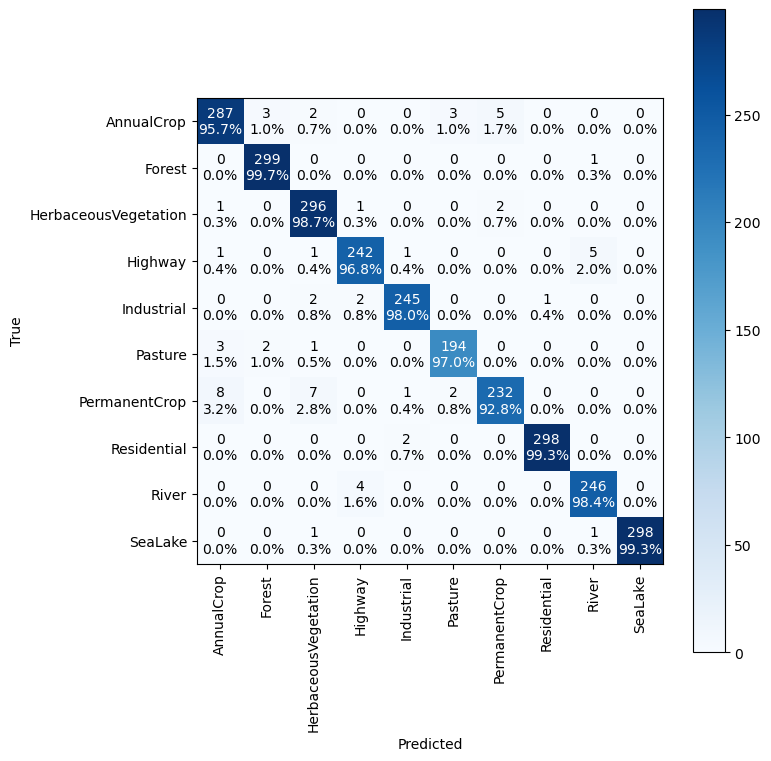


>>> Final Test Accuracy:
  Overall:              97.7%
  Weighted class acc.:  97.7%

Class                    Acc   Train+Val     Test
-------------------------------------------------
AnnualCrop              95.7%         11%       11%
Forest                  99.7%         11%       11%
HerbaceousVegetation    98.7%         11%       11%
Highway                 96.8%          9%        9%
Industrial              98.0%          9%        9%
Pasture                 97.0%          7%        7%
PermanentCrop           92.8%          9%        9%
Residential             99.3%         11%       11%
River                   98.4%          9%        9%
SeaLake                 99.3%         11%       11%


final_test_acc,▁
weighted_class_acc,▁
final_test_acc,97.66667
weighted_class_acc,97.66667


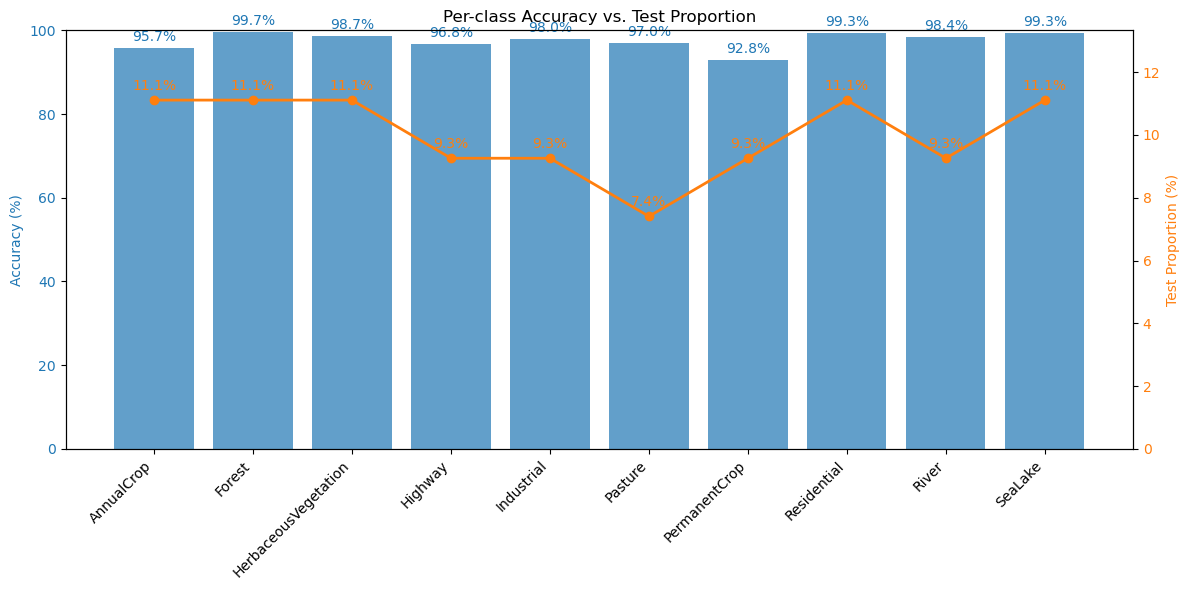

Final model saved to models/eurosat_supervised_final_bs128_lr4e-04_epcs34.pth


In [11]:
# Main
set_seed(SEED)

best_cfg, _    = hyperparam_search(pretrained=False)
bs, lr, wd     = best_cfg
tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)

# Retrain on TRAIN+VAL
final_model, combined_ds = retrain_final_model(tr_dl, val_dl, n_cls, bs, lr, wd, NUM_EPOCHS)

evaluate_and_log(final_model, te_dl, combined_ds, n_cls, bs, lr)

final_path = f"models/eurosat_supervised_final_bs{bs}_lr{lr:.0e}_epcs{NUM_EPOCHS}.pth"
torch.save(final_model.state_dict(), final_path)
print(f"Final model saved to {final_path}")
